In [2]:
%load_ext autoreload
%autoreload 2
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.fft as fft
from scipy.ndimage import gaussian_filter1d
from scipy import signal

# Configuraciones de estilos de Mapplot
# ==============================================================================
plt.style.use('seaborn-whitegrid')
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

# Omitir los Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuracion de impresión de pandas
# ==============================================================================
pd.set_option("display.precision", 8)
pd.set_option('display.width', 1000)

# Preparación de la señal (en PC)

In [102]:
!rm -rf data_original
!rm -rf segmentado
!mkdir segmentado
!mkdir data_original
!cp -r emperatriz*/* data_original/
!cp -r milca*/* data_original/
!cp -r milton*/* data_original/
!cp -r raul*/* data_original/
print("¡Realizado!")

¡Realizado!


In [98]:
len(os.listdir("data_original"))

1085

In [99]:
# nSamplesInSegment: numero de filas que van en un segmento
# nOverlap: numero de filas que se van a superponer
def sampleSegmentation(data, nSamplesInSegment, nOverlap):
    segments = []
    nSamples = len(data)
    for i in range(0, nSamples, nSamplesInSegment-nOverlap):
        if i + nSamplesInSegment > nSamples:
            break
        segments.append(data[slice(i, i + nSamplesInSegment, 1)])
    return segments


def generateSamples(fileName, dir_segmentado):
    numSamples = 100
    numOverlap = 25
    df = pd.read_csv(fileName)
    segments = sampleSegmentation(df, numSamples, numOverlap)
    for i in range(len(segments)):
        f_path_parts = fileName.split("/")
        f_name, f_ext = f_path_parts[-1].split(".")
        segment_file_name = dir_segmentado + f_name + "_" + str(i) + "." + f_ext
        if os.path.exists(segment_file_name):
            os.remove(segment_file_name)
        segments[i].to_csv(segment_file_name)

### Ejemplo

In [5]:
#generateSamples("data_original/emperatriz_caminando_mujer_adulto_20210306122006.csv", 'segmentado/')

## Revisando la señal

In [65]:
def out_gravity(df, per=.5):
    gravity = [0.0, 0.0, 0.0]
    alpha = 0.8
    for index, row in df.iterrows():
        gravity[0] = alpha * gravity[0] + (1 - alpha) * row["x"]
        gravity[1] = alpha * gravity[1] + (1 - alpha) * row["y"]
        gravity[2] = alpha * gravity[2] + (1 - alpha) * row["z"]

        df.loc[index, "x"] = row["x"] - gravity[0]
        df.loc[index, "y"] = row["y"] - gravity[1]
        df.loc[index, "z"] = row["z"] - gravity[2]
    return df[0:int(per*len(df))]

In [3]:
df_0 = pd.read_csv('data_original/milton_caminando_varon_adulto_20210306083705.csv')
df_1 = pd.read_csv('data_original/milton_sentado_varon_adulto_20210306174604.csv')
df_2 = pd.read_csv('data_original/milton_saltando_varon_adulto_20210306114600.csv')
df_3 = pd.read_csv('data_original/milton_corriendo_varon_adulto_20210324082429.csv')
df_4 = pd.read_csv('data_original/milton_subiendo_varon_adulto_20210324095953.csv')
df_0.shape, df_1.shape, df_2.shape, df_3.shape, df_4.shape

((250, 13), (250, 13), (250, 13), (250, 13), (250, 13))

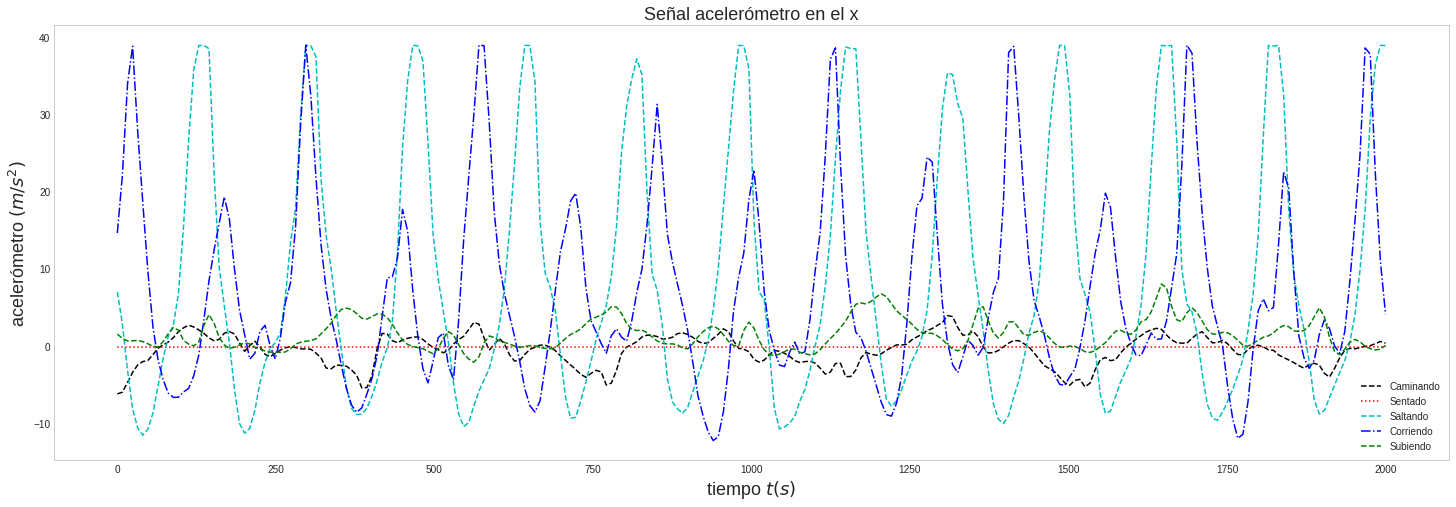

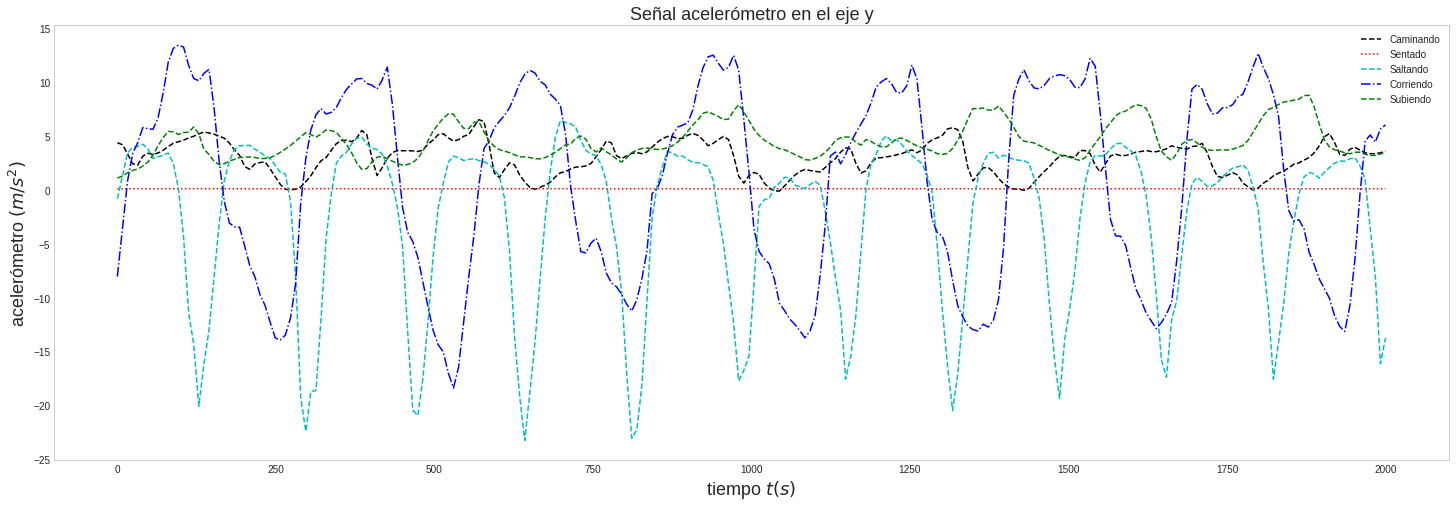

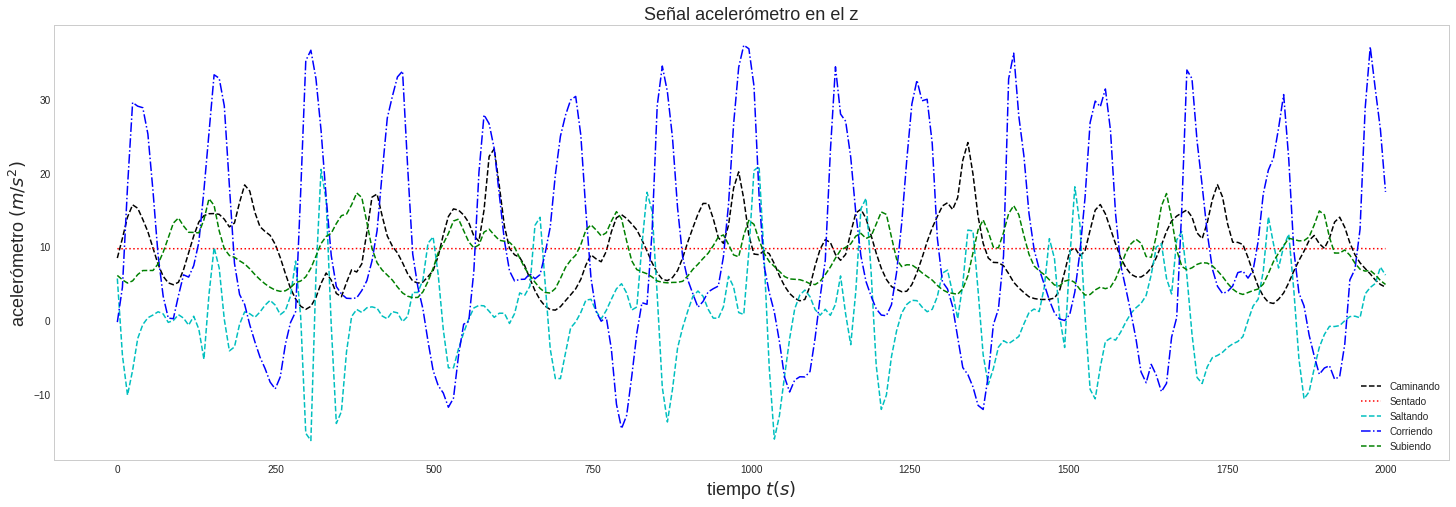

In [7]:
dx = np.linspace(0, 2000, 250) 

plt.figure(figsize=(25, 8))
plt.plot(dx, df_0.x, 'k', label='Caminando', linestyle="dashed")
plt.plot(dx, df_1.x, 'r', label='Sentado', linestyle="dotted")
plt.plot(dx, df_2.x, 'c', label='Saltando', linestyle="dashed")
plt.plot(dx, df_3.x, 'b', label='Corriendo', linestyle="dashdot")
plt.plot(dx, df_4.x, 'g', label='Subiendo', linestyle="dashed")
plt.xlabel('tiempo $t(s)$', fontsize=18)
plt.ylabel('acelerómetro $(m/s^2)$', fontsize=18)
plt.title('Señal acelerómetro en el x', fontsize=18)
plt.legend()
plt.grid()
#plt.show()
plt.savefig('foo1.png')

plt.figure(figsize=(25, 8))
plt.plot(dx, df_0.y, 'k', label='Caminando', linestyle="dashed")
plt.plot(dx, df_1.y, 'r', label='Sentado', linestyle="dotted")
plt.plot(dx, df_2.y, 'c', label='Saltando', linestyle="dashed")
plt.plot(dx, df_3.y, 'b', label='Corriendo', linestyle="dashdot")
plt.plot(dx, df_4.y, 'g', label='Subiendo', linestyle="dashed")
plt.xlabel('tiempo $t(s)$', fontsize=18)
plt.ylabel('acelerómetro $(m/s^2)$', fontsize=18)
plt.title('Señal acelerómetro en el eje y', fontsize=18)
plt.legend()
plt.grid()
#plt.show()
plt.savefig('foo2.png')
plt.figure(figsize=(25, 8))
plt.plot(dx, df_0.z, 'k', label='Caminando', linestyle="dashed")
plt.plot(dx, df_1.z, 'r', label='Sentado', linestyle="dotted")
plt.plot(dx, df_2.z, 'c', label='Saltando', linestyle="dashed")
plt.plot(dx, df_3.z, 'b', label='Corriendo', linestyle="dashdot")
plt.plot(dx, df_4.z, 'g', label='Subiendo', linestyle="dashed")
plt.xlabel('tiempo $t(s)$', fontsize=18)
plt.ylabel('acelerómetro $(m/s^2)$', fontsize=18)
plt.title('Señal acelerómetro en el z', fontsize=18)
plt.legend()
plt.grid()
#plt.show()

plt.savefig('foo3.png')
plt.show()
# plt.figure(figsize=(25, 8))
# plt.plot(np.linspace(0, 2000, 250), df_0.z, 'k', label='Data Original')
# plt.plot(np.linspace(0, 2000, 250),ss, 'r', label='Data Filtrada')
# plt.legend()
# plt.show()

## Aplicando un filtro de suavisado

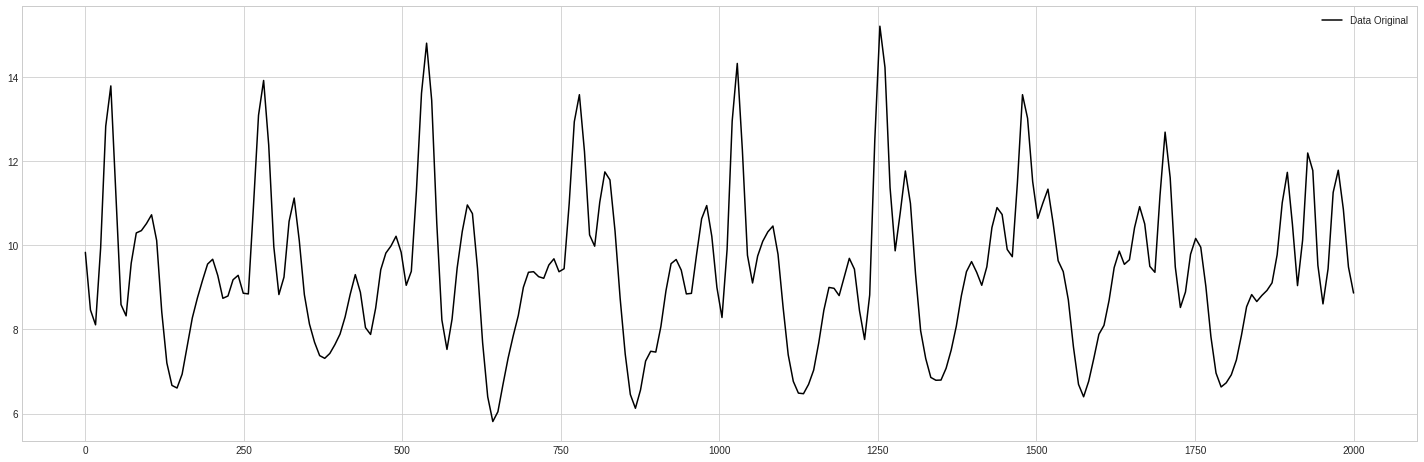

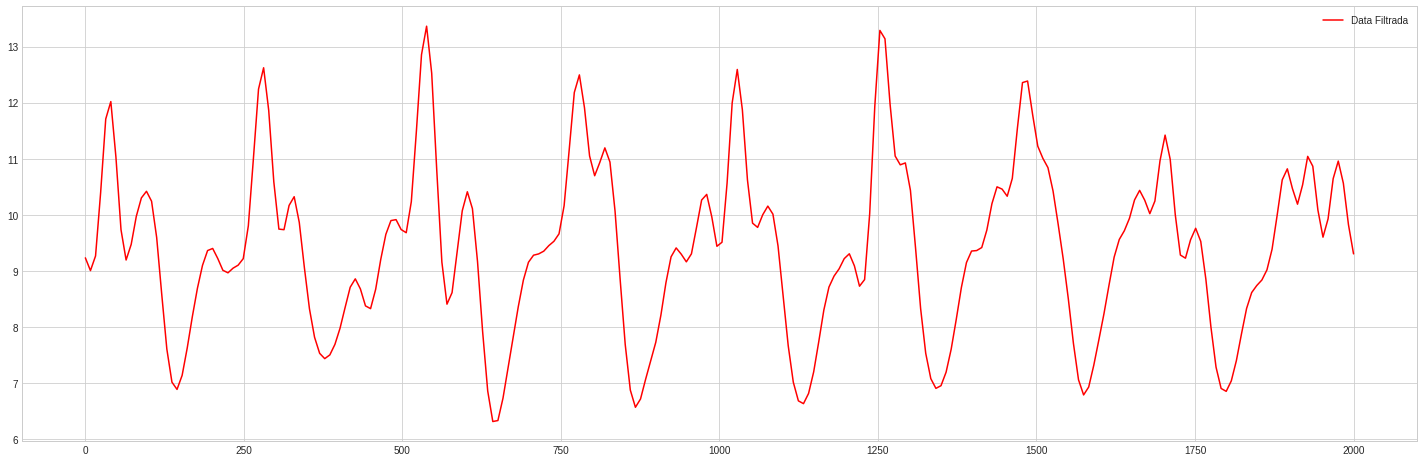

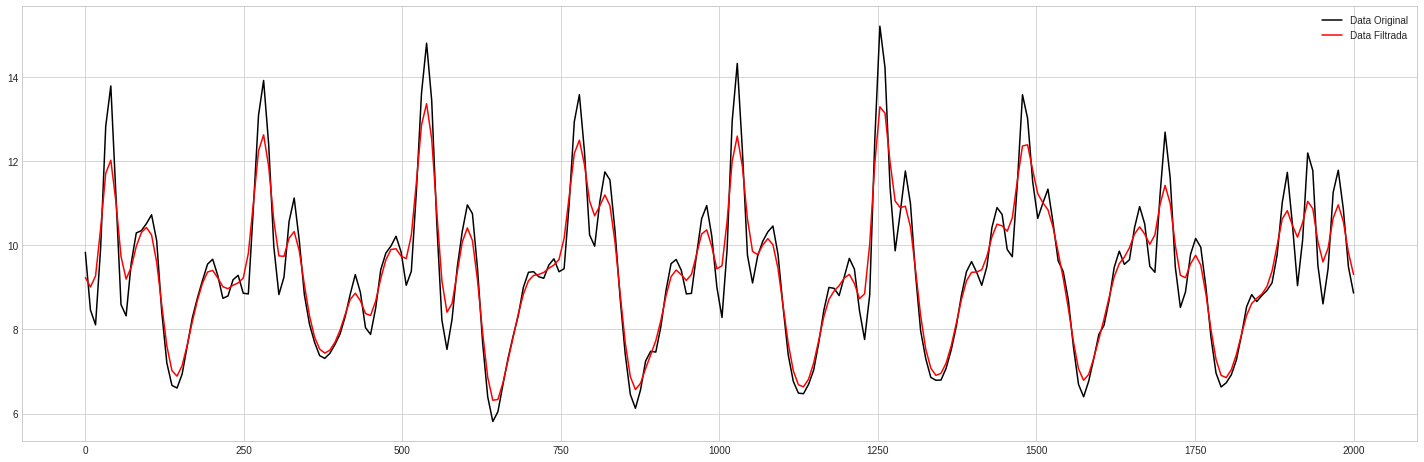

In [104]:
df_0 = pd.read_csv('data_original/emperatriz_caminando_mujer_adulto_20210306122006.csv')

ejex = int(1*250)
plt.figure(figsize=(25, 8))
ss = gaussian_filter1d(df_0.z,1.2)

plt.plot(np.linspace(0, 2000, ejex), df_0.z, 'k', label='Data Original')
plt.legend()
plt.show()


plt.figure(figsize=(25, 8))
plt.plot(np.linspace(0, 2000, ejex),ss, 'r', label='Data Filtrada')
plt.legend()
plt.show()

plt.figure(figsize=(25, 8))
plt.plot(np.linspace(0, 2000, ejex), df_0.z, 'k', label='Data Original')
plt.plot(np.linspace(0, 2000, ejex),ss, 'r', label='Data Filtrada')
plt.legend()
plt.show()

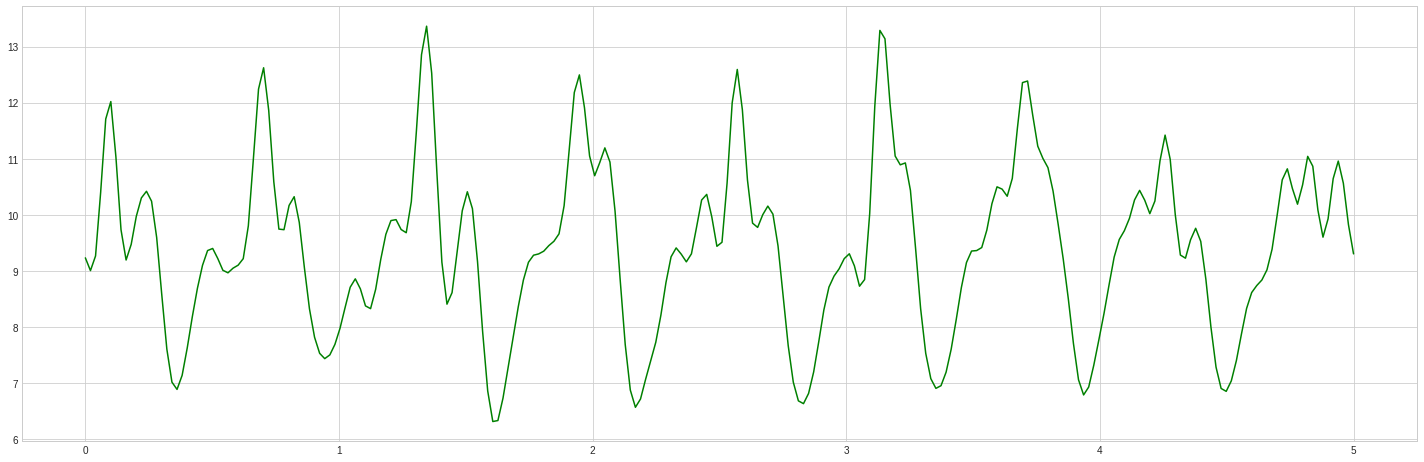

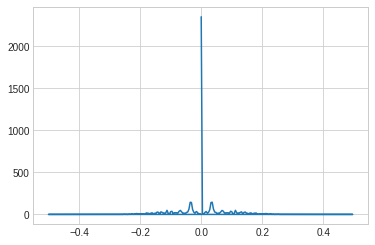

In [105]:
plt.figure(figsize=(25, 8))
fs = len(ss)
# plt.plot(np.array([i for i in range(0, fs)]), data)
plt.plot(np.linspace(0, 5, fs), ss, color="g")
# Leyenda, etiqueta y título
#plt.legend()
#plt.axhline(y=0, color="r", linestyle=":")
#plt.axvline(x=0, color="r", linestyle=":")


# Mostrando el gráfico
plt.show()

spectrum = fft.fft(ss)
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

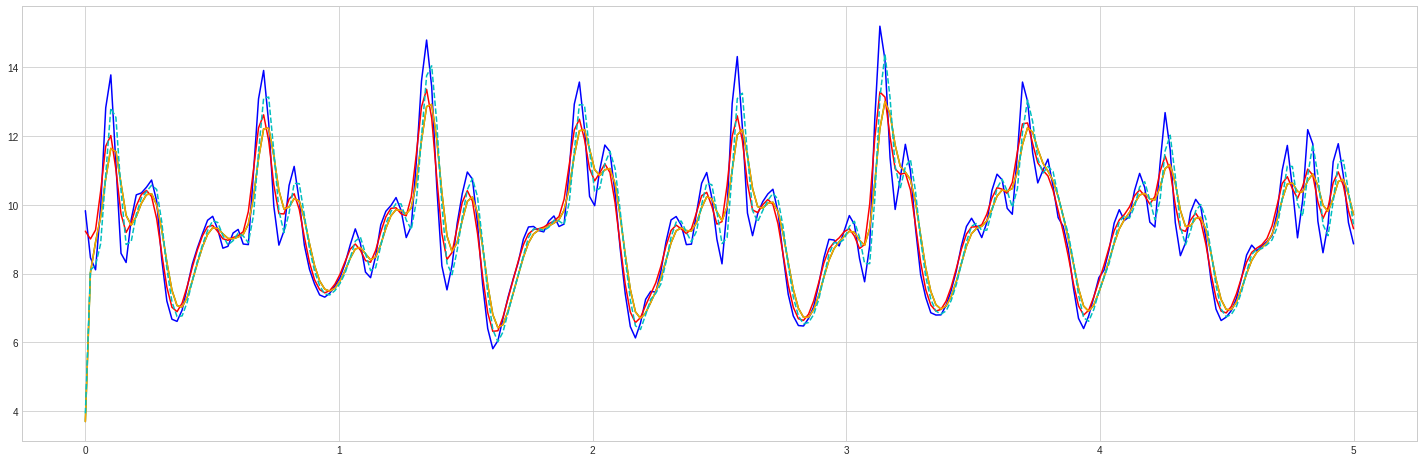

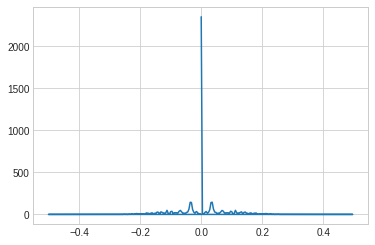

In [106]:
plt.figure(figsize=(25, 8))
sos = signal.cheby1(1, 2, 0.3, 'lowpass', output='sos')
lb_x = signal.sosfilt(sos,ss)
lb_x1 = signal.sosfilt(sos,df_0.z)
fs = len(ss)

# plt.plot(np.array([i for i in range(0, fs)]), data)
plt.plot(np.linspace(0, 5, fs), lb_x, color="g")
plt.plot(np.linspace(0, 5, fs), df_0.z, color="b")
plt.plot(np.linspace(0, 5, fs), ss, color="r")
plt.plot(np.linspace(0, 5, fs), lb_x, color="orange")
plt.plot(np.linspace(0, 5, fs), lb_x1, '--',color="c")
# Leyenda, etiqueta y título
#plt.legend()
#plt.axhline(y=0, color="r", linestyle=":")
#plt.axvline(x=0, color="r", linestyle=":")


# Mostrando el gráfico
plt.show()

spectrum = fft.fft(ss)
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

## Creación de dataset


In [107]:
df_0 = out_gravity(pd.read_csv('data_original/emperatriz_caminando_mujer_adulto_20210306122006.csv'))
df_0.head(5)

,MM,dd,HH,mm,ss,sss,x,y,z,actividad,sexo,edad,nombre
0,3,6,12,20,9,75,-0.50227050,2.73647464,7.86462400,CAMINANDO,MUJER,ADULTO,emperatriz
1,3,6,12,20,9,95,-0.72934326,2.52627683,5.19707040,CAMINANDO,MUJER,ADULTO,emperatriz
2,3,6,12,20,9,115,-0.21094045,2.18479099,3.87513672,CAMINANDO,MUJER,ADULTO,emperatriz
3,3,6,12,20,9,135,0.63187022,1.80815999,4.56153538,CAMINANDO,MUJER,ADULTO,emperatriz
4,3,6,12,20,9,155,0.50646053,0.45532927,5.96202110,CAMINANDO,MUJER,ADULTO,emperatriz


In [108]:
def spectral_centroid(x, spect_x):
    magnitudes = np.abs(spect_x)
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length)[:length//2 + 1])
    magnitudes = magnitudes[:length//2 + 1]
    return np.sum(magnitudes*freqs) / np.sum(magnitudes)

In [109]:
def magnitude(x, y, z):
    ln = len(x)
    sum = 0
    for i in range(ln):
        sum = sum + math.sqrt(x[i]**2 + y[i]**2 + z[i]**2)
    return sum/ln

In [110]:
dataset_array = []

dir_original_data = 'data_original/'  # carpeta con todos los csv
dir_segmentos = 'segmentado/'  # carpeta donde se almacenaran los nuevos csv creados


# Generando toda las muestras (3 por cada una)
data_original = os.listdir(dir_original_data) 
for mfile in data_original:
    complete_name = dir_original_data + mfile

    if not os.path.isfile(complete_name):
        continue

    generateSamples(complete_name, dir_segmentos)


data_contents = os.listdir(dir_segmentos)
row_id = 0
for mfile in data_contents:
    complete_name = dir_segmentos + mfile

    if not os.path.isfile(complete_name):
        continue
    df_content = pd.read_csv(complete_name)

    lb_x = gaussian_filter1d(df_content.x, 1)
    lb_y = gaussian_filter1d(df_content.y, 1)
    lb_z = gaussian_filter1d(df_content.z, 1)
    #lb_x = df_content.x
    #lb_y = df_content.y
    #lb_z = df_content.z

    # Filtro Digital Pasabajas Chebyshev
    #sos = signal.cheby1(1, 2, 0.3, 'low', output='sos')
    #lb_x = signal.sosfilt(sos, lb_x)
    #lb_y = signal.sosfilt(sos, lb_y)
    #lb_z = signal.sosfilt(sos, lb_z)

    spect_x = abs(fft.fft(lb_x))
    spect_y = abs(fft.fft(lb_y))
    spect_z = abs(fft.fft(lb_z))
    data_class = mfile.split("_")
    class_label = data_class[1]

    spectral_centroid_x = spectral_centroid(lb_x, spect_x)
    spectral_centroid_y = spectral_centroid(lb_y, spect_y)
    spectral_centroid_z = spectral_centroid(lb_z, spect_z)

    magnit = magnitude(lb_x, lb_y, lb_z)
    adm_x = np.average(abs(lb_x - magnit))
    adm_y = np.average(abs(lb_y - magnit))
    adm_z = np.average(abs(lb_z - magnit))

    magnitSpect = magnitude(spect_x, spect_y, spect_z)
    admSpect_x = np.average(abs(spect_x - magnitSpect))
    admSpect_y = np.average(abs(spect_y - magnitSpect))
    admSpect_z = np.average(abs(spect_z - magnitSpect))

    row = []
    row.append(row_id) # id
    row.append(np.mean(lb_x)) # media
    row.append(np.mean(lb_y)) # media
    row.append(np.mean(lb_z)) # media
    row.append(np.mean(spect_x))  # media
    row.append(np.mean(spect_y))  # media
    row.append(np.mean(spect_z))  # media
    row.append(np.median(lb_x)) # mediana
    row.append(np.median(lb_y)) # mediana
    row.append(np.median(lb_z)) # mediana
    row.append(np.median(spect_x)) # mediana
    row.append(np.median(spect_y)) # mediana
    row.append(np.median(spect_z)) # mediana
    row.append(spectral_centroid_x) # spectral centroid
    row.append(spectral_centroid_y) # spectral centroid
    row.append(spectral_centroid_z) # spectral centroid
    row.append(magnit) # magnitude
    row.append(adm_x) # Average Difference from Mean
    row.append(adm_y) # Average Difference from Mean
    row.append(adm_z) # Average Difference from Mean
    row.append(magnitSpect)  # magnitude spect
    row.append(admSpect_x)  # Average Difference from Mean Spect
    row.append(admSpect_y)  # Average Difference from Mean Spect
    row.append(admSpect_z)  # Average Difference from Mean Spect
    row.append(class_label)
    dataset_array.append(row)
    row_id = row_id + 1

cols = ["id", "mean_x", "mean_y", "mean_z", "mean_fft_x", "mean_fft_y", "mean_fft_z", 
        "median_x", "median_y", "median_z", "median_fft_x", "median_fft_y", "median_fft_z", 
        "spec_cent_x", "spec_cent_y", "spec_cent_z", 'magnitude', 
        "adm_x", "adm_y", "adm_z", 
        'magnitudeSpect', "admSpect_x", "admSpect_y", "admSpect_z",
        "class"]

dataset = pd.DataFrame(data=dataset_array, columns=cols)
dataset.head()

,id,mean_x,mean_y,mean_z,mean_fft_x,mean_fft_y,mean_fft_z,median_x,median_y,median_z,...,spec_cent_z,magnitude,adm_x,adm_y,adm_z,magnitudeSpect,admSpect_x,admSpect_y,admSpect_z,class
0,0,-0.19786469,2.92511887,9.43151724,4.14741510,6.29128538,17.32669366,-0.11928686,2.90234751,9.31623721,...,0.02902647,9.93628064,10.13414532,7.01116177,1.31655631,19.91713937,16.50604203,19.59785965,24.91791594,caminando
1,1,0.02953598,2.78740402,9.22252688,3.20390046,5.95007479,18.10719291,-0.04575884,2.67365089,9.26770164,...,0.03105300,9.68003393,9.65049795,6.89262991,1.42681809,20.03284393,16.82894346,19.59340325,25.22885470,caminando
2,2,0.10149323,2.85380630,9.55625537,4.44650821,6.90946591,17.15389621,0.10170451,2.91601401,9.65873996,...,0.02490747,10.04411944,9.94262621,7.19031314,1.27344882,20.13029765,16.03963402,19.24465564,25.63714185,caminando
3,3,-0.11798233,3.24171509,9.08221541,3.59004773,6.18414739,17.22515247,-0.31756542,3.36178316,9.41875457,...,0.03208356,9.69316264,9.81114497,6.45144755,1.16571386,19.44515545,16.13432692,19.37659060,23.78184669,caminando
4,4,-0.29145462,3.30062454,9.33887376,4.66005981,5.99109084,16.30678703,-0.29380562,3.35211070,9.66968329,...,0.02505423,9.96739291,10.25884752,6.66676836,1.06358982,19.15294249,15.80896654,19.38004188,24.32526748,caminando


In [111]:
dataset.describe()

,id,mean_x,mean_y,mean_z,mean_fft_x,mean_fft_y,mean_fft_z,median_x,median_y,median_z,...,spec_cent_y,spec_cent_z,magnitude,adm_x,adm_y,adm_z,magnitudeSpect,admSpect_x,admSpect_y,admSpect_z
count,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,...,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000
mean,1627.00000000,2.81001177,1.67374789,7.69496483,24.67589905,16.02190712,26.33664378,1.51758502,2.86716137,6.95846643,...,0.05010222,0.04952958,12.42094209,11.30205970,10.74973097,5.90222611,44.43261541,43.10916233,42.09869068,45.58068296
std,939.78188959,3.99398834,2.70271834,2.64975372,25.10801549,14.24303323,15.27712295,2.30102441,2.42844575,3.05192140,...,0.02604319,0.03559058,3.23235634,3.16123996,4.58847046,5.37867711,30.58786932,31.27707034,27.80119553,24.45231955
min,0.00000000,-9.91177262,-9.18113872,-1.11313356,0.03872487,0.06743435,8.25871035,-7.83683664,-8.66745979,-1.57456081,...,0.00084285,0.00018122,9.31820306,5.42940910,2.96042898,0.00306361,9.79915812,9.70656811,9.67624897,17.82910460
25%,813.50000000,0.01395250,0.11071579,6.81890146,4.86787228,7.00734283,15.72655836,0.00986150,0.19445909,5.01017227,...,0.02934701,0.02781645,9.82029503,9.50964689,6.60173501,1.51327690,20.60216277,17.28146280,20.69263940,24.73611042
50%,1627.00000000,1.03447037,2.48580887,8.84780682,8.85766337,9.94811170,21.40885840,0.67601406,3.06337194,8.35997153,...,0.04555417,0.04592665,10.14482243,9.99025466,9.63637237,2.83314609,27.90004481,24.52459277,27.10968940,32.91336168
75%,2440.50000000,6.97632000,3.59509529,9.52307157,49.32212331,27.52126234,37.25525752,3.52805880,4.33296926,9.38647235,...,0.06656401,0.07336631,15.21602273,12.63877595,14.57913129,11.62801362,76.22377795,76.56767131,71.21333751,70.43556506
max,3254.00000000,10.58165924,7.09303238,11.31973737,92.98972876,72.78769860,84.92610758,8.05959465,9.60420362,11.16091921,...,0.15810309,0.16983314,21.10962328,29.91931439,23.73793117,17.59237625,116.15959955,112.16204279,100.66367852,111.33987199


# Modelado / Entrenamiento

In [112]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.preprocessing import Normalizer
import joblib
import itertools

## Read Dataset

In [113]:
ds = dataset.drop(['id'], axis=1)
ds.shape

(3255, 24)

## Datset Cleaning 

### Verificando Outliers

In [114]:
ds.skew()

mean_x            0.13348588
mean_y           -1.33298782
mean_z           -1.51744816
mean_fft_x        0.61463090
mean_fft_y        0.94609723
mean_fft_z        0.93447053
median_x          0.09592429
median_y          0.11185249
median_z         -1.00895686
median_fft_x      1.69943814
median_fft_y      2.71638756
median_fft_z      1.58141607
spec_cent_x      -0.39991902
spec_cent_y       0.71672491
spec_cent_z       0.37797504
magnitude         0.78619524
adm_x             2.52921053
adm_y             0.59351841
adm_z             0.37957658
magnitudeSpect    0.39337457
admSpect_x        0.40333880
admSpect_y        0.32845183
admSpect_z        0.46900626
dtype: float64

<AxesSubplot:>

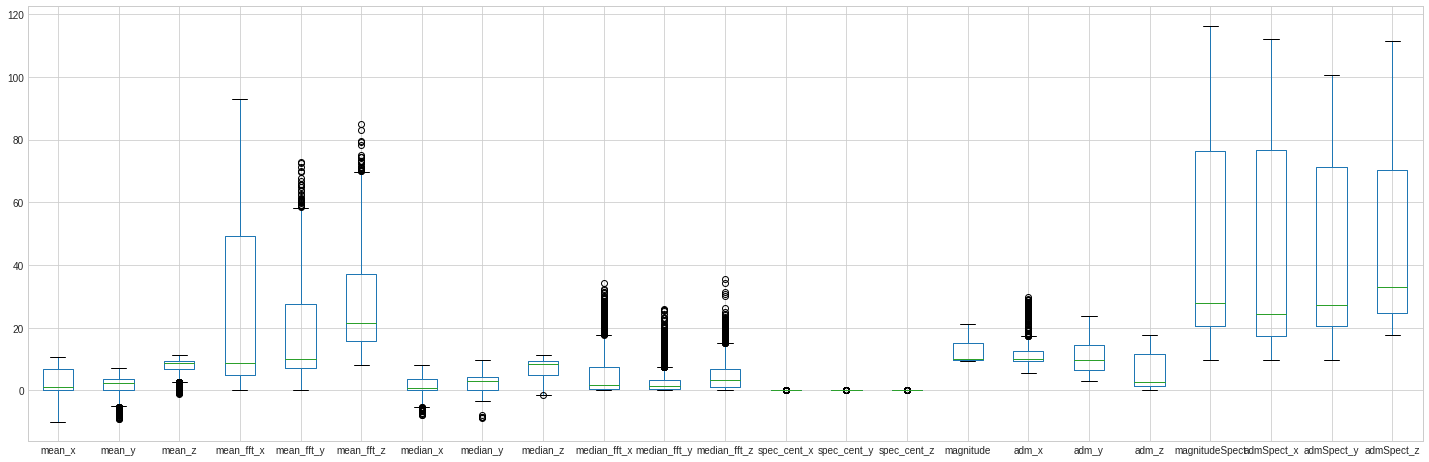

In [115]:
ds.boxplot(figsize=(25, 8))

In [116]:
zsc = np.abs(stats.zscore(ds.drop(["class"], axis=1), axis=1))
print("Filas que tiene mínimo un outlier en alguna columna:", zsc[(zsc > 2.2)].shape[0])
print("Filas que tiene mínimo un outlier en todas las columnas:", zsc[(zsc > 2.2).all(axis=1)].shape[0])

Filas que tiene mínimo un outlier en alguna columna: 2049
Filas que tiene mínimo un outlier en todas las columnas: 0


In [117]:
Q1 = ds.iloc[:, :-1].quantile(0.25)
Q3 = ds.iloc[:, :-1].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

mean_x             6.96236750
mean_y             3.48437950
mean_z             2.70417012
mean_fft_x        44.45425102
mean_fft_y        20.51391951
mean_fft_z        21.52869916
median_x           3.51819730
median_y           4.13851018
median_z           4.37630009
median_fft_x       6.84853809
median_fft_y       2.77967041
median_fft_z       5.54383343
spec_cent_x        0.02958188
spec_cent_y        0.03721700
spec_cent_z        0.04554986
magnitude          5.39572769
adm_x              3.12912906
adm_y              7.97739628
adm_z             10.11473672
magnitudeSpect    55.62161518
admSpect_x        59.28620851
admSpect_y        50.52069811
admSpect_z        45.69945464
dtype: float64


In [118]:
ds.iloc[:, :-1] = np.where(ds.iloc[:, :-1] < (Q1 - 1.5 * IQR), Q1, ds.iloc[:, :-1])

In [119]:
ds.iloc[:, :-1] = np.where(ds.iloc[:, :-1] > (Q3 + 1.5 * IQR), Q3, ds.iloc[:, :-1])

<AxesSubplot:>

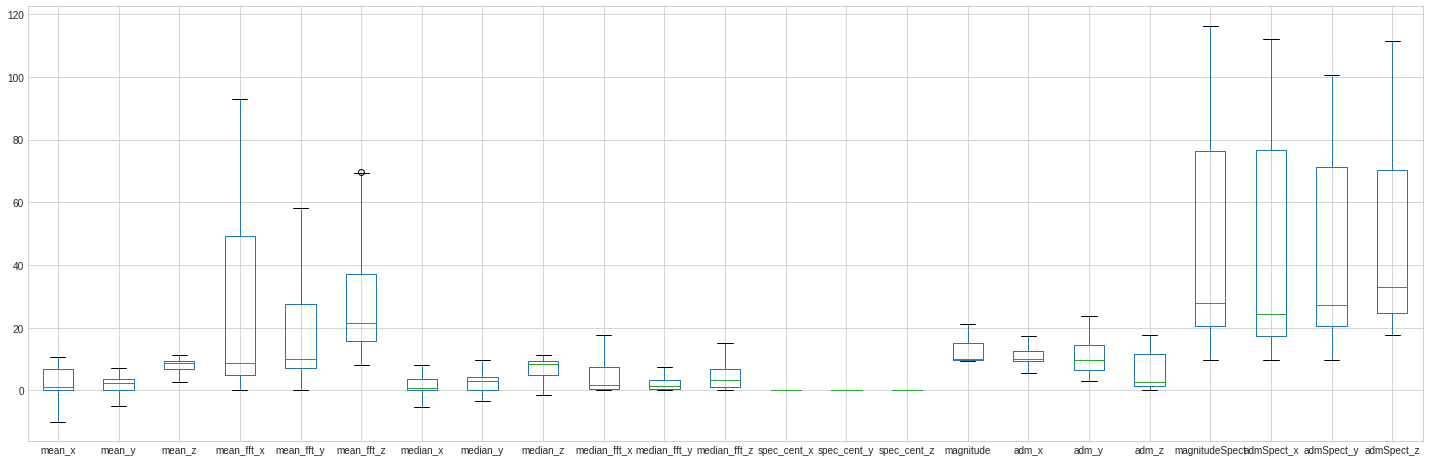

In [120]:
ds.boxplot(figsize=(25, 8))

### Verificando Balanceo de data

In [121]:
ds.groupby("class", as_index=False).agg({"class": "count"}).rename(columns = {"class":"total_x_class"})

,total_x_class
0,618
1,774
2,597
3,651
4,615


##  Data Preprocessing

In [122]:
ds["class"].value_counts()

corriendo    774
sentado      651
caminando    618
subiendo     615
saltando     597
Name: class, dtype: int64

### Codificar variables categóricas

In [123]:
ds["class"] = np.where(ds["class"] == "caminando", 0,
                       np.where(ds["class"] == "sentado", 1,
                                np.where(ds["class"] == "saltando", 2,
                                         np.where(ds["class"] == "corriendo", 3, 4
))))

In [124]:
ds["class"].value_counts()

3    774
1    651
0    618
4    615
2    597
Name: class, dtype: int64

### Normalizar

In [125]:
#features = ds.columns
X = ds.iloc[:, : -1]
y = ds["class"]

In [126]:
data_cols = list(X)
scaler = Normalizer().fit(X)
tmp_scaled = scaler.transform(X)
X = pd.DataFrame(tmp_scaled)
X.columns = data_cols
X.describe()

,mean_x,mean_y,mean_z,mean_fft_x,mean_fft_y,mean_fft_z,median_x,median_y,median_z,median_fft_x,...,spec_cent_y,spec_cent_z,magnitude,adm_x,adm_y,adm_z,magnitudeSpect,admSpect_x,admSpect_y,admSpect_z
count,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,...,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000,3255.00000000
mean,0.01860457,0.02796452,0.13018909,0.17237677,0.12939023,0.28013887,0.01083780,0.03319952,0.12182173,0.02871000,...,0.00055485,0.00044510,0.15891084,0.14804360,0.13260740,0.04387801,0.40544319,0.38404599,0.39168700,0.47523450
std,0.02437104,0.03201545,0.08993453,0.12281841,0.07387121,0.07281232,0.01474713,0.02895882,0.09693540,0.02342724,...,0.00023645,0.00025800,0.06983031,0.07757496,0.07245353,0.02723482,0.06627542,0.07267213,0.06051992,0.05777214
min,-0.14718862,-0.03634689,0.01404560,0.00110477,0.00190909,0.05295882,-0.08534865,-0.02043641,-0.00741090,0.00026758,...,0.00002351,0.00000513,0.06821501,0.05227053,0.04981270,0.00008678,0.27925131,0.26995707,0.26418663,0.31520347
25%,0.00037904,0.00311090,0.04192565,0.08927873,0.10498776,0.24637743,0.00026511,0.00372933,0.02809392,0.01075936,...,0.00040206,0.00035040,0.09591816,0.07585221,0.08565741,0.02942791,0.40204736,0.33636909,0.38673074,0.43153250
50%,0.01620695,0.01578133,0.13690932,0.13713458,0.14470887,0.27966403,0.00976515,0.03288943,0.13044422,0.02533370,...,0.00050606,0.00047985,0.15330659,0.13798322,0.10185623,0.04347012,0.42312437,0.37708276,0.41031888,0.48432945
75%,0.04015210,0.05608659,0.17650222,0.28872163,0.17167979,0.33800778,0.02215514,0.05534814,0.17385708,0.04131706,...,0.00064881,0.00061405,0.19456519,0.18937263,0.13273398,0.06644557,0.45001058,0.44533080,0.42854459,0.51674776
max,0.07589705,0.15172452,0.27848290,0.44558173,0.37324009,0.41164341,0.06520063,0.15173635,0.27846758,0.11250480,...,0.00316071,0.00164160,0.27859010,0.29709255,0.27716093,0.13371121,0.52818365,0.57353554,0.55517392,0.57832750


### Generando dato de prueba y entranamiento

In [127]:
#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.5, random_state=2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 2)

In [128]:
list(set(y_train))

[0, 1, 2, 3, 4]

## Modelo, afinamiento

Entrenamiento con varios parametros

In [130]:
nodes_per_layer= [30, 40, 50, 60, 70, 80]
learn_rate_init = [10e-6, 10e-5,10e-4, 10e-3]
train_par_res = []
for n_nodes in nodes_per_layer:
    for learn_rate in learn_rate_init:
        clf = MLPClassifier(hidden_layer_sizes=(n_nodes, n_nodes), max_iter=500,
                            learning_rate_init=learn_rate, solver='adam')
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        y_pred = clf.predict(X_test)

        acc_i = accuracy_score(y_test, y_pred)
        vals = []
        vals.append(2) #num hidden layers
        vals.append(n_nodes) #num nodes per layer
        vals.append(clf.n_iter_) #num iterations 
        vals.append(learn_rate)
        vals.append(clf.loss_) #loss
        vals.append(acc_i) #accuracy
        vals.append(train_score) #train_score
        vals.append(test_score) #test_score

        train_par_res.append(vals)

for n_nodes in nodes_per_layer:
    for learn_rate in learn_rate_init:
        clf = MLPClassifier(hidden_layer_sizes=(n_nodes, n_nodes, n_nodes), max_iter=500,
                            learning_rate_init=learn_rate, solver='adam')
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        y_pred = clf.predict(X_test)
        acc_i = accuracy_score(y_test, y_pred)
        vals = []
        vals.append(3) #num hidden layers
        vals.append(n_nodes) #num nodes per layer
        vals.append(clf.n_iter_) #num iterations 
        vals.append(learn_rate)
        vals.append(clf.loss_) #loss
        vals.append(acc_i) #accuracy
        vals.append(train_score) #train_score
        vals.append(test_score) #test_score

        train_par_res.append(vals)

cols = ["Hidden Layers", "Nodes per layer", "# iter", "learning rate", "loss", "accuracy", "train_score", "test_score"]
trains_params_dt = pd.DataFrame(data=train_par_res, columns=cols)
trains_params_dt.head()


,Hidden Layers,Nodes per layer,# iter,learning rate,loss,accuracy,train_score,test_score
0,2,30,500,0.00001,1.51650742,0.53531218,0.54872695,0.53531218
1,2,30,500,0.00010,0.40259805,0.87717503,0.88410887,0.87717503
2,2,30,500,0.00100,0.14773897,0.93654043,0.94512730,0.93654043
3,2,30,129,0.01000,0.14177032,0.95291709,0.95215101,0.95291709
4,2,40,500,0.00001,1.33091485,0.46980553,0.46619842,0.46980553


In [131]:
trains_params_dt.sort_values(by=['accuracy'], ascending=False).head(10)

,Hidden Layers,Nodes per layer,# iter,learning rate,loss,accuracy,train_score,test_score
19,2,70,153,0.010,0.10871934,0.96315251,0.97453907,0.96315251
23,2,80,118,0.010,0.09885924,0.95803480,0.96883231,0.95803480
15,2,60,103,0.010,0.10976459,0.95803480,0.96707638,0.95803480
6,2,40,354,0.001,0.12308321,0.95701126,0.95434592,0.95701126
7,2,40,102,0.010,0.11177483,0.95701126,0.96005268,0.95701126
22,2,80,427,0.001,0.12336530,0.95496418,0.95566286,0.95496418
14,2,60,452,0.001,0.11121609,0.95496418,0.96224759,0.95496418
30,3,40,423,0.001,0.11139535,0.95496418,0.96049166,0.95496418
43,3,70,94,0.010,0.11992998,0.95496418,0.95785777,0.95496418
31,3,40,135,0.010,0.11222061,0.95394063,0.96883231,0.95394063


CPU times: user 15.4 s, sys: 15 s, total: 30.3 s
Wall time: 2.68 s


0.966198419666374

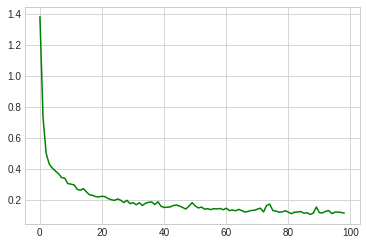

In [132]:
%%time
# clf.best_loss_, clf.loss_, clf.n_iter_
#clf = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=300)
clf = MLPClassifier(hidden_layer_sizes=(70, 70), max_iter=160, learning_rate_init=0.01, solver='adam')
#clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200, learning_rate_init=0.001)
clf.fit(X_train, y_train)
lr = clf.loss_curve_
plt.plot(range(len(lr)), lr, color="g")
clf.score(X_train, y_train)

In [133]:
clf.best_loss_, clf.loss_, clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.10565423873268372, 0.1138733901172873, 0.966198419666374, 0.962128966223132)

In [134]:
filename = 'modelo_deteccion_v4.uni'
joblib.dump(clf, filename)

['modelo_deteccion_v4.uni']

In [135]:
y_pred = clf.predict(X_test)

In [136]:
temp = pd.DataFrame(clf.predict_proba(X_test), columns=["a", "b", "c", "d", "e"])
temp.columns
rg1 = 0.15
rg2 = 0.35

temp[((temp.a < rg2) & (temp.a > rg1)) & ((temp.b < rg2) & (temp.b > rg1))]
# Parece que nunca va encontrar ninguno

,a,b,c,d,e


In [137]:
accuracy_score(y_test, y_pred)

0.962128966223132

In [138]:
cm = confusion_matrix(y_test.values, y_pred)
cm

array([[167,   0,   0,   0,  19],
       [  0, 195,   0,   0,   0],
       [  0,   0, 176,   3,   0],
       [  0,   0,   0, 232,   0],
       [ 15,   0,   0,   0, 170]])

In [139]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '0.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('Etiquetas verdaderas', )
    plt.xlabel('Etiquetas predecidas')

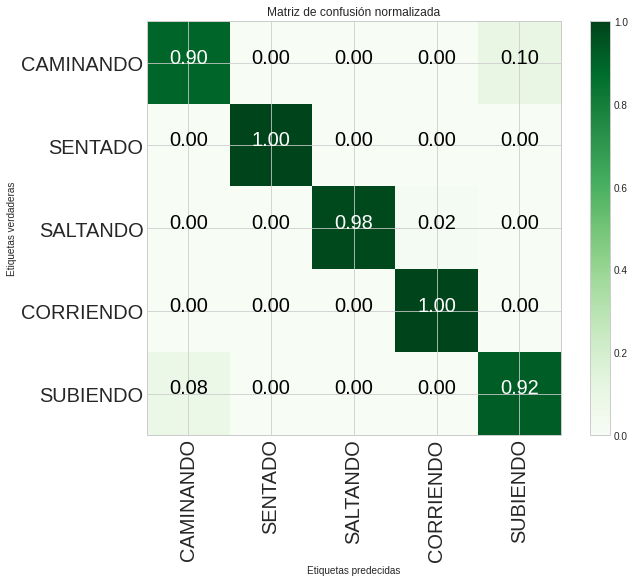

In [140]:
labels = ['CAMINANDO', 'SENTADO', 'SALTANDO', 'CORRIENDO', 'SUBIENDO']
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Matriz de confusión normalizada', cmap = plt.cm.Greens)

In [141]:
#= np.where(ds["class"] == "caminando", 0, np.where(ds["class"] == "sentado", 1, 2))
var_tmp = pd.DataFrame(y_test)
var_tmp["pred"] = y_pred
var_tmp["caminando"] = np.where((var_tmp["class"] == var_tmp["pred"]) & (var_tmp["class"] == 0), 1, 0)
var_tmp["sentado"] = np.where((var_tmp["class"] == var_tmp["pred"]) & (var_tmp["class"] == 1), 1, 0)
var_tmp["saltando"] = np.where((var_tmp["class"] == var_tmp["pred"]) & (var_tmp["class"] == 2), 1, 0)
var_tmp["corriendo"] = np.where((var_tmp["class"] == var_tmp["pred"]) & (var_tmp["class"] == 3), 1, 0)
var_tmp["subiendo"] = np.where((var_tmp["class"] == var_tmp["pred"]) & (var_tmp["class"] == 4), 1, 0)
var_tmp

,class,pred,caminando,sentado,saltando,corriendo,subiendo
2132,2,2,0,0,1,0,0
2759,3,3,0,0,0,1,0
3098,1,1,0,1,0,0,0
561,1,1,0,1,0,0,0
921,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
1453,1,1,0,1,0,0,0
2910,2,2,0,0,1,0,0
834,4,4,0,0,0,0,1
1003,3,3,0,0,0,1,0


In [142]:
var_tmp.groupby(["caminando", "sentado", "saltando", "corriendo", "subiendo"], as_index=False).agg({"caminando": "sum", "sentado": "sum", "saltando": "sum", "corriendo": "sum", "subiendo": "sum"})

,caminando,sentado,saltando,corriendo,subiendo
0,0,0,0,0,0
1,0,0,0,0,170
2,0,0,0,232,0
3,0,0,176,0,0
4,0,195,0,0,0
5,167,0,0,0,0


In [143]:
cm

array([[167,   0,   0,   0,  19],
       [  0, 195,   0,   0,   0],
       [  0,   0, 176,   3,   0],
       [  0,   0,   0, 232,   0],
       [ 15,   0,   0,   0, 170]])

In [144]:
model = joblib.load("modelo_deteccion_v4.uni")

In [145]:
X_test.iloc[1:2,:]

,mean_x,mean_y,mean_z,mean_fft_x,mean_fft_y,mean_fft_z,median_x,median_y,median_z,median_fft_x,...,spec_cent_y,spec_cent_z,magnitude,adm_x,adm_y,adm_z,magnitudeSpect,admSpect_x,admSpect_y,admSpect_z
2759,-0.02249009,0.01874202,0.04793543,0.25458827,0.16167819,0.30694203,-0.01594525,0.02355965,0.03915769,0.04110075,...,0.00029739,0.00038552,0.08672204,0.07261613,0.06862505,0.06011655,0.45978548,0.43759474,0.41274262,0.46012217


In [146]:
y_pred = model.predict(X_test)

In [147]:
cm = confusion_matrix(y_test.values, y_pred)

In [148]:
cm

array([[167,   0,   0,   0,  19],
       [  0, 195,   0,   0,   0],
       [  0,   0, 176,   3,   0],
       [  0,   0,   0, 232,   0],
       [ 15,   0,   0,   0, 170]])

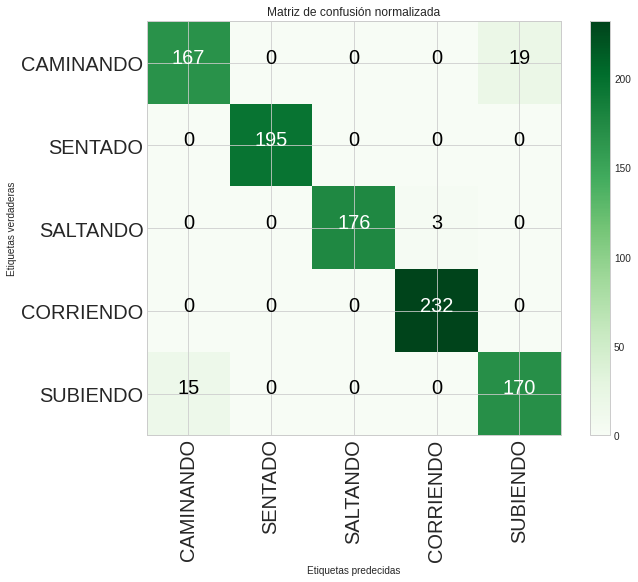

In [149]:
labels = ['CAMINANDO', 'SENTADO', 'SALTANDO', 'CORRIENDO', 'SUBIENDO']
plot_confusion_matrix(cm, classes=labels, normalize=False, title='Matriz de confusión normalizada', cmap = plt.cm.Greens)

In [150]:
model.score(X_test, y_test)

0.962128966223132